In [2]:
import os
import sys
import subprocess
import collections
import time
import nbformat
import socket
import re
import pickle

import numpy as np
import sklearn.metrics

import torch

lib_path = 'I:/code'
if not os.path.exists(lib_path):
  lib_path = '/media/6T/.tianle/.lib'
if not os.path.exists(lib_path):
  lib_path = '/projects/academic/azhang/tianlema/lib'
if os.path.exists(lib_path) and lib_path not in sys.path:
  sys.path.append(lib_path)
  
from dl.utils.visualization.visualization import *
from dl.utils.train import eval_classification, get_label_prob
from dl.utils.utils import *

%load_ext autoreload
%autoreload 2

In [2]:
def submit_job(model_type='nn', dense=False, residual=True, hidden_dim=[500, 500], 
               train_portion=0.7, val_portion=0.1, test_portion=0.2, 
               num_sets=10, num_folds=10, sel_set_idx=0,
               num_train_types=-1, 
               num_val_types=-1,
               num_test_types=-1,
               cv_type='instance-shuffle',
               sel_disease_types='all', 
               min_num_samples_per_type_cls=[100, 0],
               predefined_sample_set_file='auto-search',
               target_variable='PFI',
               target_variable_type='discrete',
               target_variable_range=[0, 1],
               data_type=['gene', 'mirna', 'methy', 'rppa'], 
               additional_vars=[],#['age_at_initial_pathologic_diagnosis', 'gender']
               additional_var_types=[],#['continuous', 'discrete']
               additional_var_ranges=[],
               normal_transform_feature=True, 
               randomize_labels=False,
               lr=5e-4,
               weight_decay=1e-4,
               num_epochs=1000,
               reduce_every=500,
               show_results_in_notebook=True, 
               idx_folder='results/data_split_idx', # no longer used
               notebook_folder='.', 
               template_file='exp_template.ipynb', 
               slurm_script='../gpu-slurm', 
               new_file=True, submit=True,
               cell_idx=2, gpu_id=3):
  """Create notebook and run it on dlm or submit to ccr slurm
  """
  # This is for filename
  if sel_disease_types == 'all':
    sel_disease_type_str = 'all' 
  else:
    sel_disease_type_str = '-'.join(sorted(sel_disease_types))
  if isinstance(data_type, str):
    data_type_str = data_type
  else:
    data_type_str = '-'.join(sorted(data_type))
  if model_type == 'nn': # model_type, dense, residual are dependent
    assert not (residual and dense)
    if residual:
      model_type = 'resnet' 
    if dense:
      model_type = 'densenet'
  
  args = {'model_type': model_type, # model_type may be different from the argument
          'dense': dense,
          'residual': residual,
          'hidden_dim': hidden_dim,
          'train_portion': train_portion,
          'val_portion': val_portion,
          'test_portion': test_portion,
          'num_sets': num_sets,
          'num_folds': num_folds,
          'num_train_types': num_train_types, 
          'num_val_types': num_val_types,
          'num_test_types': num_test_types,
          'cv_type': cv_type,
          'sel_set_idx': sel_set_idx,
          'sel_disease_types': sel_disease_types,
          'min_num_samples_per_type_cls': min_num_samples_per_type_cls,
          'predefined_sample_set_file': predefined_sample_set_file,
          'target_variable': target_variable,
          'target_variable_type': target_variable_type,
          'target_variable_range': target_variable_range,
          'data_type': data_type,
          'additional_vars': additional_vars,#['age_at_initial_pathologic_diagnosis', 'gender']
          'additional_var_types': additional_var_types,#['continuous', 'discrete']
          'additional_var_ranges': additional_var_ranges,
          'normal_transform_feature': normal_transform_feature,
          'randomize_labels': randomize_labels,
          'lr': lr,
          'weight_decay': weight_decay,
          'num_epochs': num_epochs,
          'reduce_every': reduce_every,
          'show_results_in_notebook': show_results_in_notebook
         }
  
  predefined_sample_set_filename = (target_variable if isinstance(target_variable,str) 
                                else '-'.join(target_variable))
  predefined_sample_set_filename += f'_{cv_type}'
  if len(additional_vars) > 0:
    predefined_sample_set_filename += f"_{'-'.join(sorted(additional_vars))}"
  predefined_sample_set_filename += (f"_{data_type_str}_{sel_disease_type_str}_"
                                     f"{'-'.join(map(str, min_num_samples_per_type_cls))}")
  predefined_sample_set_filename += f"_{'-'.join(map(str, [train_portion, val_portion, test_portion]))}"
  if cv_type == 'group-shuffle' and num_train_types > 0:
    predefined_sample_set_filename += f"_{'-'.join(map(str, [num_train_types, num_val_types, num_test_types]))}"
  predefined_sample_set_filename += f'_{num_sets}sets'
  filename_prefix = f"{predefined_sample_set_filename}_{sel_set_idx}_{'-'.join(map(str, hidden_dim))}_{model_type}"
  filename = f'{filename_prefix}.ipynb'
  nb = nbformat.read(f'{notebook_folder}/{template_file}', 4)
  nb['cells'][0]['source'] = ("import socket\nif socket.gethostname() == 'dlm':\n"
                              "  %env CUDA_DEVICE_ORDER=PCI_BUS_ID\n"
                              f"  %env CUDA_VISIBLE_DEVICES={gpu_id}")
  nb['cells'][cell_idx]['source'] = '\n'.join(
    [f"{k} = '{v}'" if isinstance(v, str) else f'{k} = {v}' for k, v in args.items()])
  if os.path.exists(f'{notebook_folder}/{filename}'):
    print(f'To overwrite file {notebook_folder}/{filename}')
  else:
    print(f'To create file {notebook_folder}/{filename}')
  if new_file:
    nbformat.write(nb, f'{notebook_folder}/{filename}')
  
  if submit: # sometimes I just want to create files
    if re.search('ccr.buffalo.edu$', socket.gethostname()):
      command = f'sbatch {slurm_script} {notebook_folder}/{filename} {filename}'
      subprocess.run(command, shell=True)
      print(command)
    else:
      command = ['jupyter nbconvert', '--ExecutePreprocessor.timeout=360000',
               '--ExecutePreprocessor.allow_errors=True', '--to notebook', '--execute']
      command.append(f'{notebook_folder}/{filename} --output {filename}')
      command = ' '.join(command)
      start_time = time.time()
      tmp = subprocess.run(command, shell=True)
      end_time = time.time()
      print(f'Time spent: {end_time-start_time:.2f}')
  return filename_prefix

In [3]:
data_folder = '../../pan-can-atlas/data/processed'
if not os.path.exists(data_folder):
  data_folder = 'F:/TCGA/Pan-Cancer-Atlas/data/processed'
with open(f'{data_folder}/sel_patient_clinical.pkl', 'rb') as f:
  data = pickle.load(f)
  disease_types = data['disease_types']
  disease_type_dict = data['disease_type_dict']
  pfi = data['pfi']
disease_stats = {}
for idx, name in disease_type_dict.items():
  cnt = list(collections.Counter(pfi[disease_types==idx]).values())
  if cnt[0] > 100 and cnt[1] > 100:
    disease_stats[idx] = f'{name}: {cnt}'
    print(name, idx, cnt)

BLCA 0 [191, 147]
BRCA 1 [740, 107]
KIRC 6 [295, 151]
LGG 8 [273, 150]
LUAD 10 [144, 211]
LUSC 11 [102, 202]
SARC 16 [115, 102]
STAD 17 [106, 224]


In [4]:
for i in ['all']:#[0, 1, 6, 8, 10, 11, 16, 17]:
  for j in range(1):
      for dtype in [['gene', 'mirna', 'rppa', 'methy']]:
        submit_job(model_type='ml', dense=False, residual=False, hidden_dim=[100,100], 
               train_portion=0.7, val_portion=0.1, test_portion=0.2, 
               num_sets=10, num_folds=10, sel_set_idx=j,
               num_train_types=-1, 
               num_val_types=-1,
               num_test_types=-1,
               cv_type='instance-shuffle',
               sel_disease_types=i, 
               min_num_samples_per_type_cls=[100, 0],
               predefined_sample_set_file='auto-search',
               target_variable='DFI',
               target_variable_type='discrete',
               target_variable_range=[0,1],
               data_type=dtype, 
               additional_vars=[],#['age_at_initial_pathologic_diagnosis', 'gender']
               additional_var_types=[],#['continuous', 'discrete']
               additional_var_ranges=[],
               normal_transform_feature=True, 
               randomize_labels=False,
               lr=5e-4,
               weight_decay=1e-4,
               num_epochs=100,
               reduce_every=500,
               show_results_in_notebook=True, 
               idx_folder='results/data_split_idx', # no longer used
               notebook_folder='.', 
               template_file='exp_template-mv-ml-v2.ipynb', 
               slurm_script='../run-slurm', 
               new_file=False, submit=False,
               cell_idx=2, gpu_id=1)

To create file ./DFI_instance-shuffle_gene-methy-mirna-rppa_all_100-0_0.7-0.1-0.2_10sets_0_100-100_ml.ipynb


In [9]:
def load_results(disease_type_str = '0', #0-1-6-8-10-11-16-17
                  model_name = 'ml',
                  sel_set_idx = 0,
                  data_type_str = 'gene-mirna-rppa-methy',
                  data_split_str = '70-10-20',
                  hidden_dim_str = '100-100',
                  filefolder = 'results',
                  target_variable = 'pfi',
                  return_variable='metric_all',
                  filename=None, plot_acc=True, plot_loss=True):
  if filename is None:
    filename = (f'{filefolder}/{disease_type_str}_{data_type_str}_set{sel_set_idx}' 
                f'_{data_split_str}_{target_variable}_{hidden_dim_str}_{model_name}.pkl')
    
  with open(filename, 'rb') as f:
    data = pickle.load(f)
  if return_variable in data:
    return np.array(data[return_variable])
  metric = np.array(data['metric_all'])
  confusion_mat = np.array(data['confusion_mat_all'])
  model_names, split_names, metric_names = (data['model_names'], data['split_names'], 
                                            data['metric_names'])
  # sanity check
  assert metric.shape == (len(model_names), len(split_names), len(metric_names))
  assert confusion_mat.shape[:2] == (len(model_names), len(split_names))
  loss_his = data['loss_his_all']
  acc_his = np.array(data['acc_his_all'])
  title =  disease_type_str if len(disease_type_str)>2 else disease_stats[int(disease_type_str)]
  if plot_acc and len(acc_his)>0:
    for i, n in enumerate(split_names):
      plot_history(acc_his[:, i].T, title=f'{title} {n} acc', 
                   indices=None, colors='rgbkmc', markers='ov+*,<',
                       labels=model_names, linestyles=['']*6, markersize=3)
    for i, n in enumerate(model_names):
      plot_history(acc_his[i].T, title=f'{title} {n} acc', 
                   indices=None, colors='rgbkmc', markers='ov+*,<',
                       labels=split_names, linestyles=['']*6, markersize=3)
  if plot_loss and len(loss_his)>0:
    for i, n in enumerate(model_names):
      history = np.array(loss_his[i])
      if history.ndim == 2:
        plot_history(history.T, title=f'{title} {n} loss', indices=None, colors='rgbkmc', 
                     markers='ov+*,<',
                       labels=split_names, linestyles=['']*6, markersize=3)
      elif history.ndim == 3:
        for j in range(history.shape[2]):
           plot_history(history[:,:,j].T, title=f'{title} {n} loss{j}', indices=None, 
                        colors='rgbkmc', markers='ov+*,<',
                       labels=split_names, linestyles=['']*6, markersize=3)
      else:
        raise ValueError(f'{filename} {n} loss has unexpected shape')
  if return_variable == 'all':
    return metric, confusion_mat, model_names, split_names, metric_names, acc_his, loss_his

# These results are used for BIBM 2018 submission
I ran 1000 iterations for each experiments;

This is for PFI only. I forgot how I processed DFI, probably based on partial data.

In [10]:
# This is used to delete unused files and clean up disk space
filenames = set()
for i in ['all']:
  for j in range(10):
    for model_name in ['resnet', 'ml', 'densenet', 'nn']:
      filename = f'results/{i}_gene-mirna-rppa-methy_set{j}_70-10-20_pfi_100-100_{model_name}.pkl'
      filenames.add(filename)
      if not os.path.exists(filename):
          print(filename)

for i in ['all']:
  for j in range(10):
    for data_type_str in ['gene', 'mirna', 'rppa', 'methy']:
      filename = f'results/{i}_{data_type_str}_set{j}_70-10-20_pfi_100-100_nn.pkl'
      filenames.add(filename)
      if not os.path.exists(filename):
          print(filename)

for i in ['all']:
  for j in range(10):
    for model_name in ['resnet', 'densenet', 'nn']:
      filename = f'results/{i}_gene-mirna-rppa-methy_set{j}_70-10-20_pfi_100-100-100_{model_name}.pkl'
      filenames.add(filename)
      if not os.path.exists(filename):
          print(filename)
print('Number of files with 1000 iterations (the rest 100 iterations):', len(filenames))

# I changed the number of layers and hidden units
hidden_dim_strs = ['100', '200', '100-100', '100-200', '200-100', '100-100-100', 
                   '50-100-200', '100-50-200', '200-100-50', '200-100-50-10']
for target_variable in ['PFI', 'DFI']:
  for hidden_dim_str in hidden_dim_strs:
    for seed in range(10):
      filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
                f'_100-0_0.7-0.1-0.2_10sets_{seed}_{hidden_dim_str}_nn.pkl')
      filenames.add(filename)
      if not os.path.exists(filename):
        print(filename)
# I also experiment with resnet and densenet for 100-100-100
for target_variable in ['PFI', 'DFI']:
  for model_name in ['resnet', 'densenet']:
    for seed in range(10):
      filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
                f'_100-0_0.7-0.1-0.2_10sets_{seed}_100-100-100_{model_name}.pkl')
      filenames.add(filename)
      if not os.path.exists(filename):
        print(filename)
        
model_types = ['ml', 'nn', 'densenet', 'resnet']
for target_variable in ['PFI', 'DFI']:
  for model_name in model_types:
    for seed in range(10):
      filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
                f'_100-0_0.7-0.1-0.2_10sets_{seed}_100-100_{model_name}.pkl')
      filenames.add(filename)
      if not os.path.exists(filename):
        print(filename)
# I also did four experiments on 0.5-0.2-0.3 data split        
for target_variable in ['PFI', 'DFI']:
  for shuffle_type in ['instance-shuffle', 'group-shuffle']:
    filename=(f'results/{target_variable}_{shuffle_type}_gene-methy-mirna-rppa_all'
              f'_100-0_0.5-0.2-0.3_10sets_0_100-100_nn.pkl')
    filenames.add(filename)
    if not os.path.exists(filename):
      print(filename)
print('Total number of files:', len(filenames))

# # remove old files to save disk space
# [os.remove(f'results/{f}') for f in os.listdir('results') 
#  if f.endswith('pkl') and f'results/{f}' not in filenames]

Number of files with 1000 iterations (the rest 100 iterations): 110
Total number of files: 414


In [11]:
# major results: using all the four data types with hidden_dim = [100,100]
res_all = np.array([np.concatenate(
  [load_results(disease_type_str='all', sel_set_idx=i, model_name=model_name, 
                hidden_dim_str='100-100', return_variable='metric_all') 
   for model_name in ['ml', 'resnet', 'nn', 'densenet']], axis=0) for i in range(10)])
all_model_names = np.concatenate([[f'{n}-{model_name}' for n in load_results(
  disease_type_str='all', sel_set_idx=0, model_name=model_name, hidden_dim_str='100-100', 
  return_variable='model_names')] for model_name in ['ml', 'resnet', 'nn', 'densenet']])
# I also run each data type alone using nn with hidden_dim = [100,100]
res_all = np.concatenate([res_all, 
  np.array([np.concatenate([load_results(disease_type_str='all', sel_set_idx=sel_set_idx, 
    model_name='nn', data_type_str=data_type_str, hidden_dim_str = '100-100', 
                                         return_variable='metric_all') 
    for data_type_str in ['gene', 'mirna', 'rppa', 'methy']], axis=0)
            for sel_set_idx in range(10)])], axis=1)
all_model_names = np.concatenate([all_model_names, np.concatenate([[f'{n}-nn-{data_type_str}' for n in load_results(disease_type_str='all', sel_set_idx=0, 
    model_name='nn', data_type_str=data_type_str, hidden_dim_str = '100-100', 
                                         return_variable='model_names')] 
    for data_type_str in ['gene','mirna', 'rppa', 'methy']])])
# I also try hidden_dim=[100,100,100]
res_all = np.concatenate([res_all, np.array([np.concatenate(
  [load_results(disease_type_str='all', sel_set_idx=i, model_name=model_name, 
    hidden_dim_str = '100-100-100',return_variable='metric_all') 
   for model_name in ['resnet', 'nn', 'densenet']], axis=0) for i in range(10)])], axis=1)
all_model_names = np.concatenate([all_model_names, np.concatenate(
  [[f'{n}-{model_name}-h3' for n in load_results(disease_type_str='all', sel_set_idx=0, 
                                              model_name=model_name, 
    hidden_dim_str = '100-100-100',return_variable='model_names')] 
   for model_name in ['resnet', 'nn', 'densenet']], axis=0)])
# shorten model names
all_model_names = np.array([s.replace(' ', '') for s in all_model_names])
all_model_names = np.array([s.replace('MultiviewAE', 'MAE') for s in all_model_names])

In [12]:
idx = 5
# i = 5
# subset = range(6*i, 6*i+6)
# subset = range(i, len(all_model_names), 6)
subset = range(len(all_model_names))
names = all_model_names[subset][res_all.mean(axis=0)[subset].argsort(axis=0)[:,2,idx]]
values = np.sort(res_all.mean(axis=0)[subset], axis=0)[:,2,idx]
[(i, n, v) for i, (n, v) in enumerate(zip(names, values))]

[(0, 'AE-resnet', 0.623220989523831),
 (1, 'SVM-ml', 0.6253236819104966),
 (2, 'DecisionTree-ml', 0.6344077423733231),
 (3, 'NaiveBayes-ml', 0.6447574711109004),
 (4, 'kNN-ml', 0.6594321045061513),
 (5, 'AdaBoost-ml', 0.6615472463299661),
 (6, 'RandomForest-ml', 0.6897763762705622),
 (7, 'AE-resnet-h3', 0.6901417687078062),
 (8, 'NN-nn-mirna', 0.6901648252111663),
 (9, 'AE-nn-rppa', 0.6925053046389765),
 (10, 'AE+feat_int-nn-mirna', 0.6932227798374672),
 (11, 'AE+feat_int-nn-rppa', 0.6938946529956925),
 (12, 'AE-nn-mirna', 0.6944272012090005),
 (13, 'NN-nn-rppa', 0.6953036100722294),
 (14, 'AE-nn-methy', 0.7102065502295172),
 (15, 'AE+feat_int-nn-methy', 0.7116517874606327),
 (16, 'NN-nn-methy', 0.7127151591608673),
 (17, 'NN-densenet-h3', 0.713696296667573),
 (18, 'MAE+feat_int-resnet-h3', 0.7141056748374199),
 (19, 'NN-nn', 0.7148790301213884),
 (20, 'NN-nn-gene', 0.7158680172100279),
 (21, 'AE-nn', 0.7165334039648082),
 (22, 'MAE+feat_int+view_sim-densenet-h3', 0.7165592591126861),


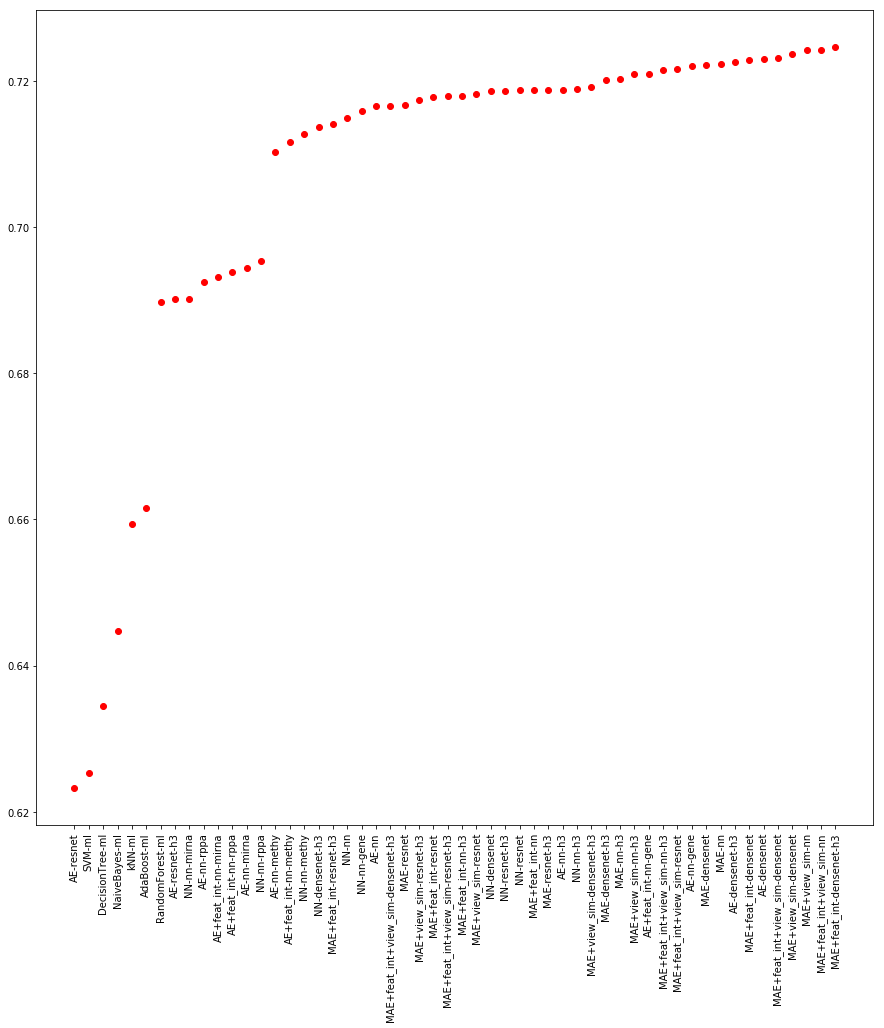

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(np.sort(res_all.mean(axis=0), axis=0)[:,2,idx], 'ro')
ax.set_xticks(np.arange(len(all_model_names)))
ax.set_xticklabels(all_model_names[res_all.mean(axis=0).argsort(axis=0)[:,2,idx]], rotation=90)
plt.show()

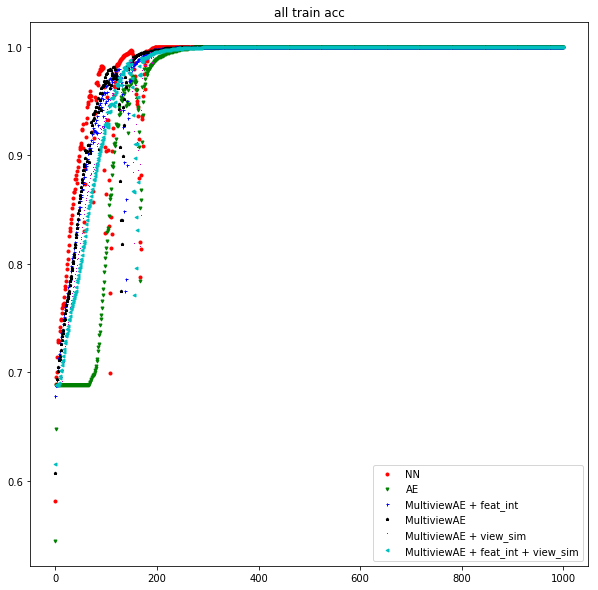

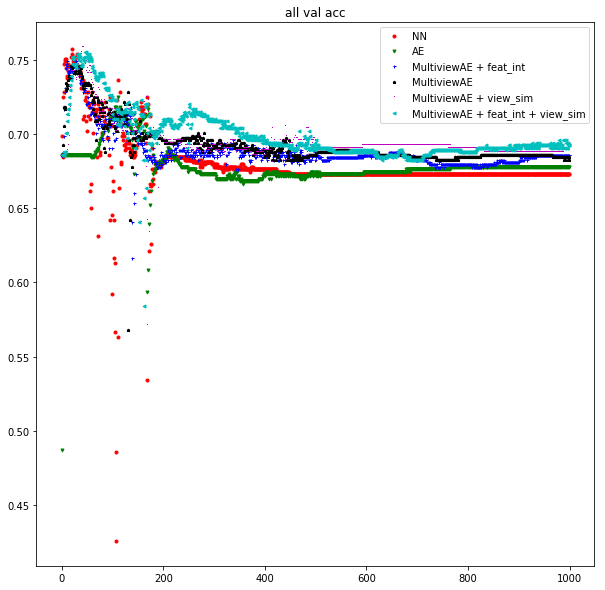

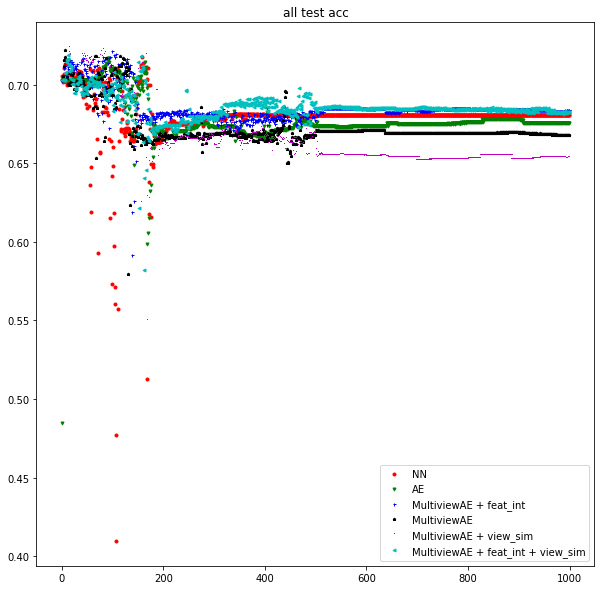

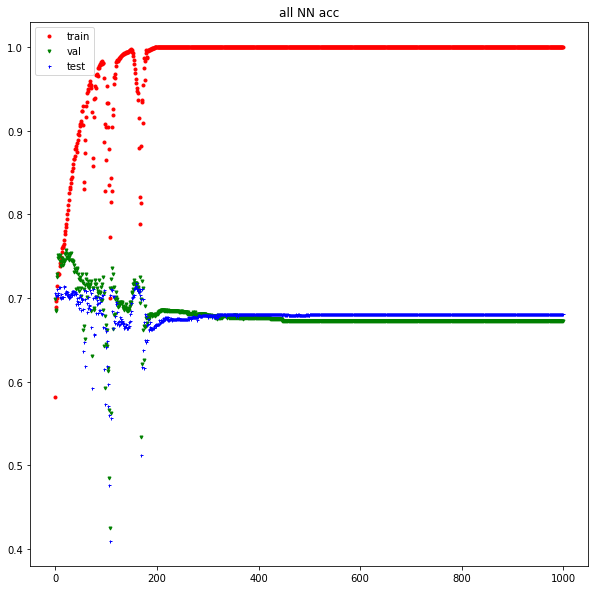

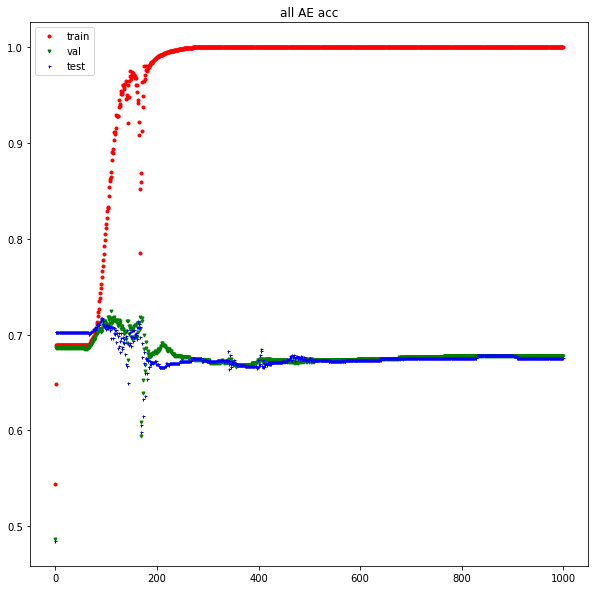

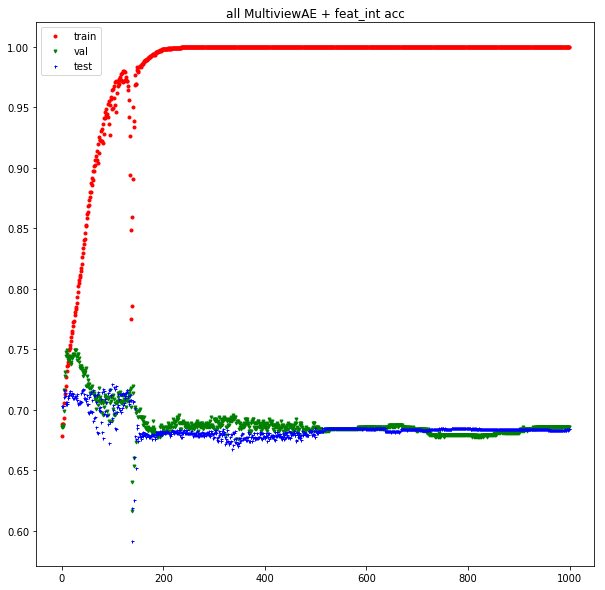

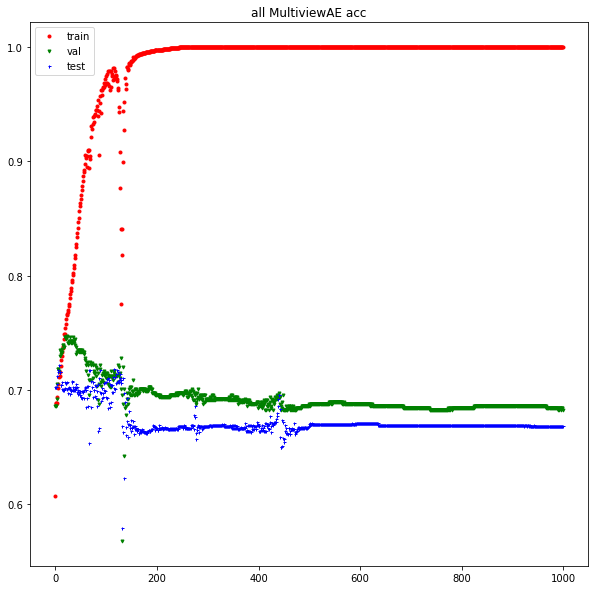

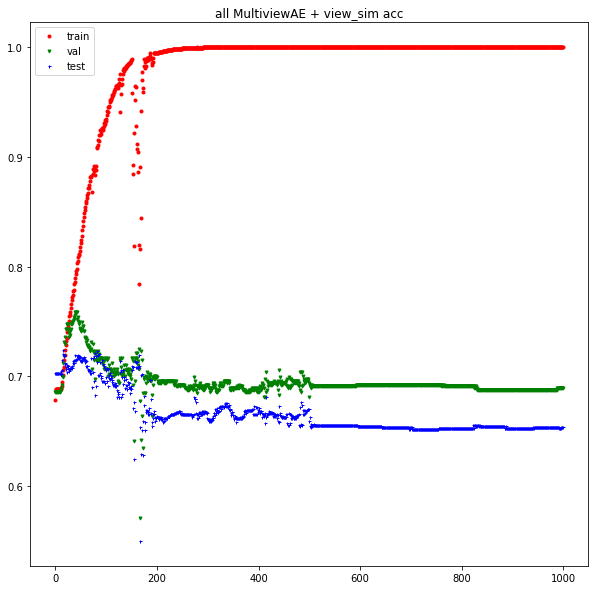

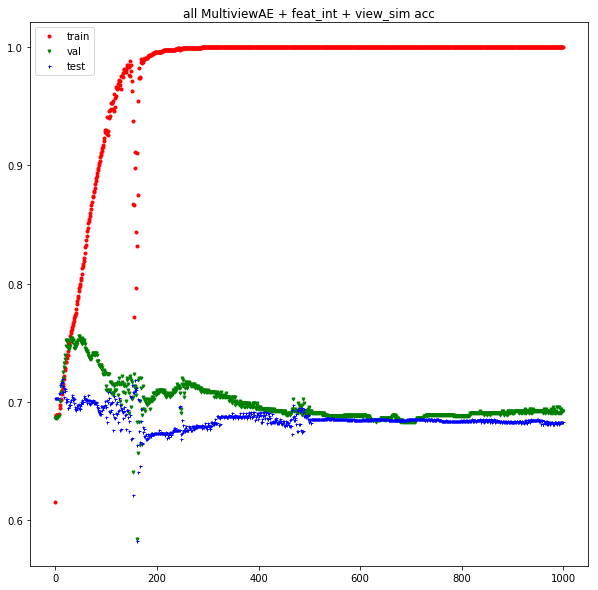

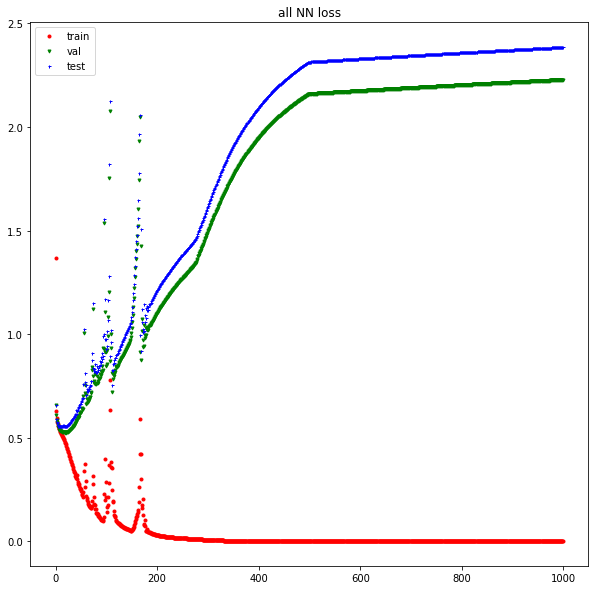

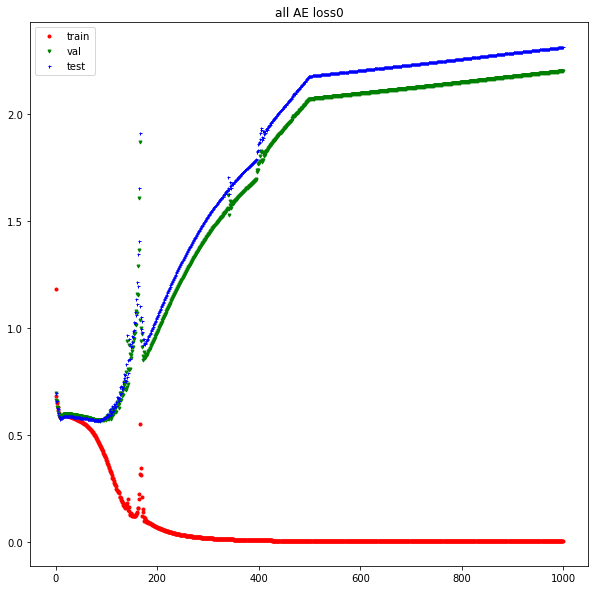

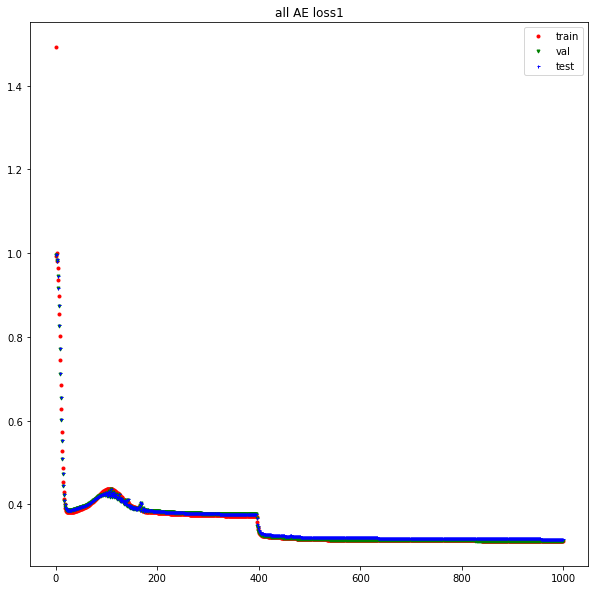

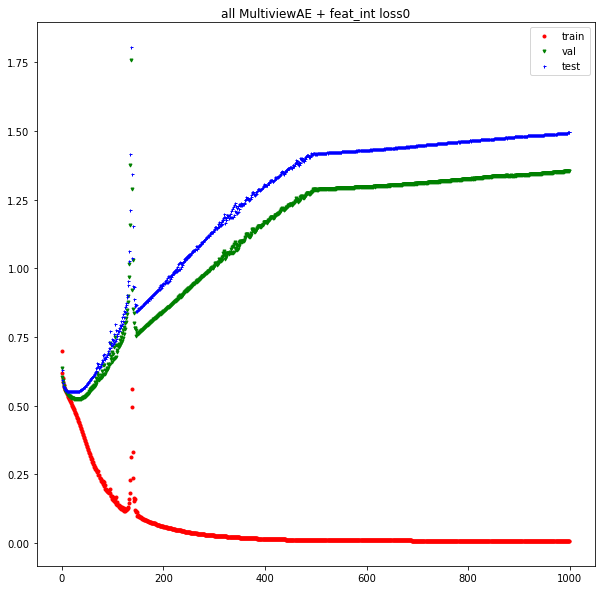

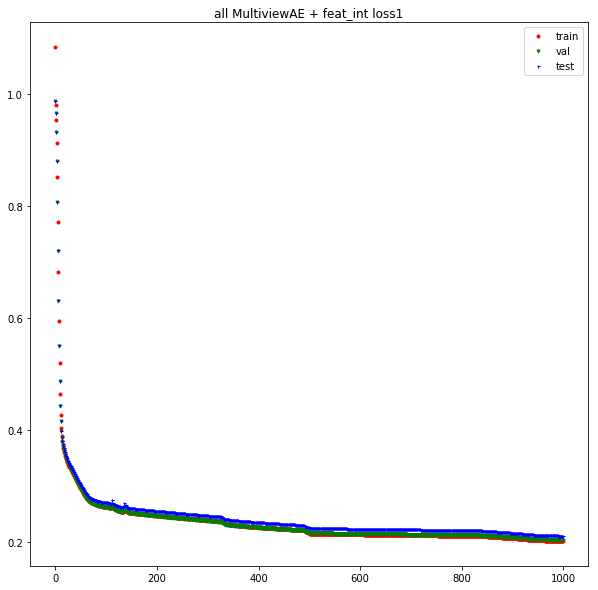

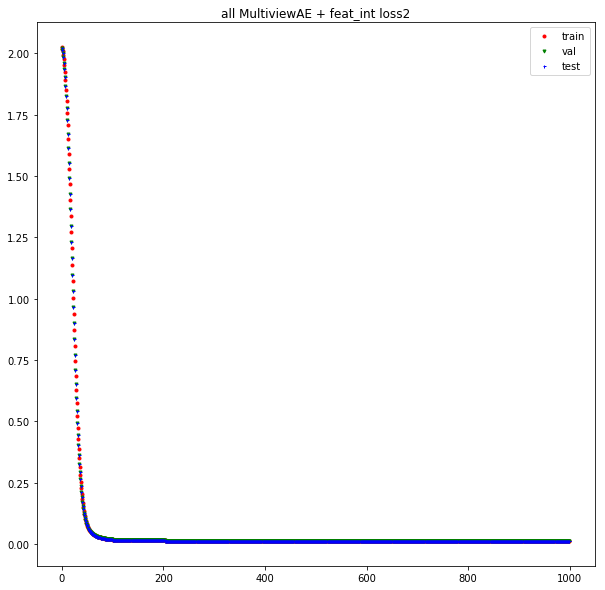

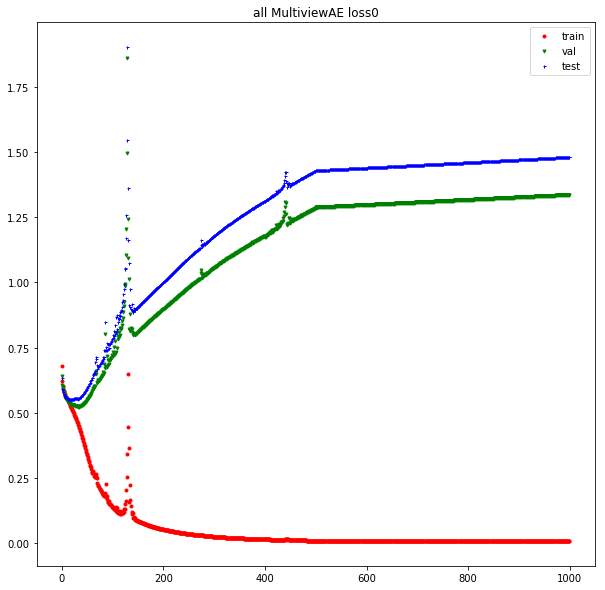

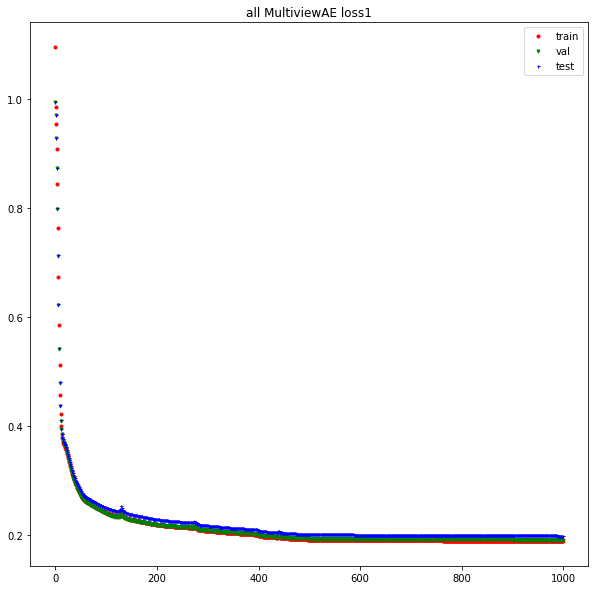

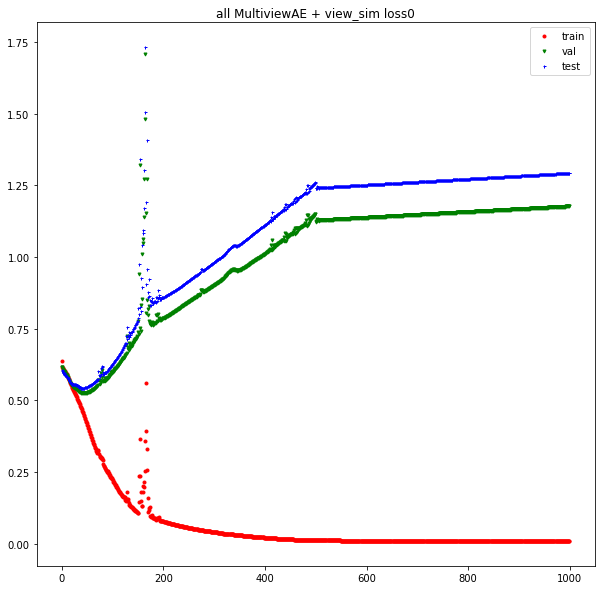

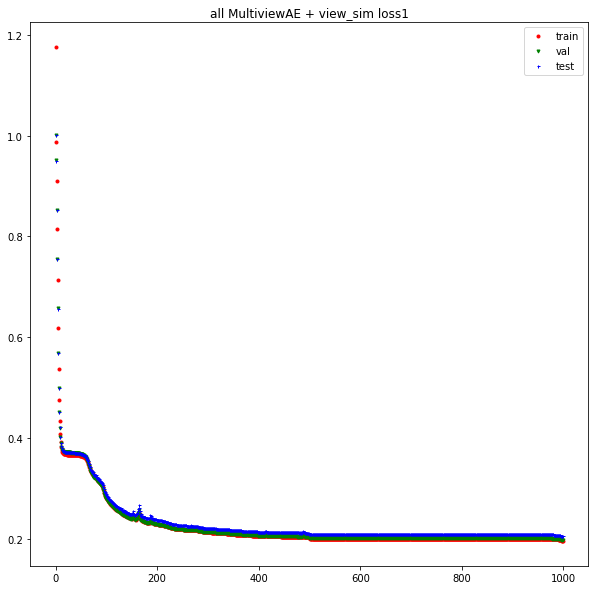

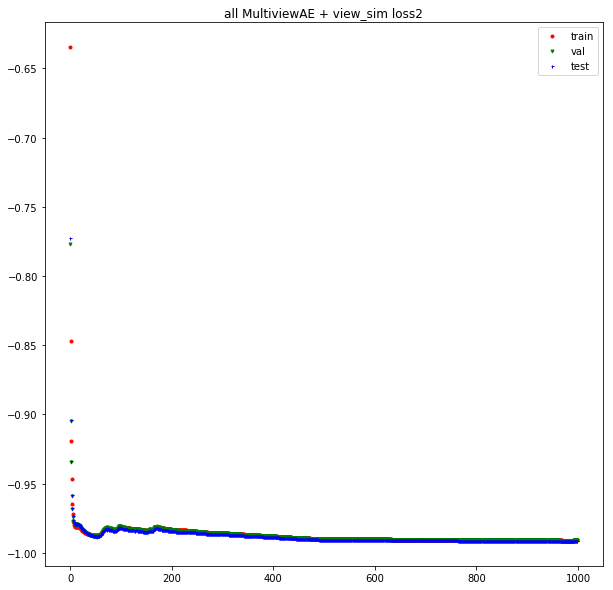

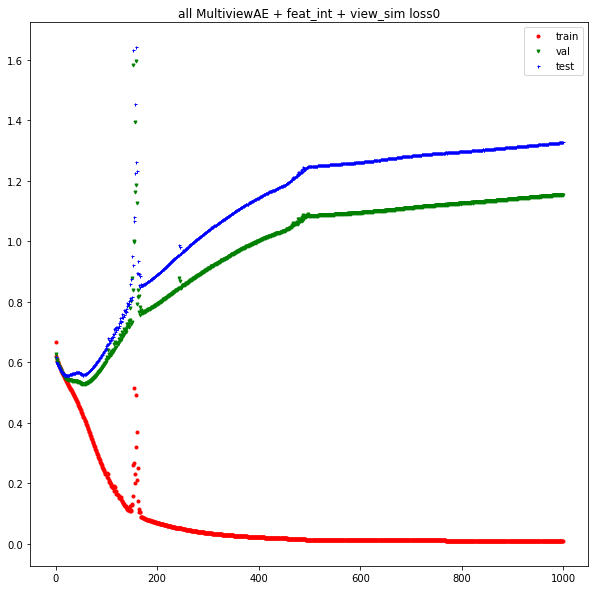

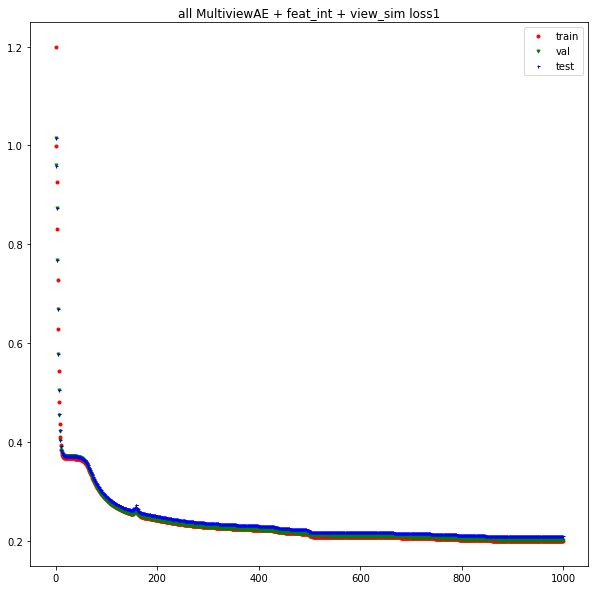

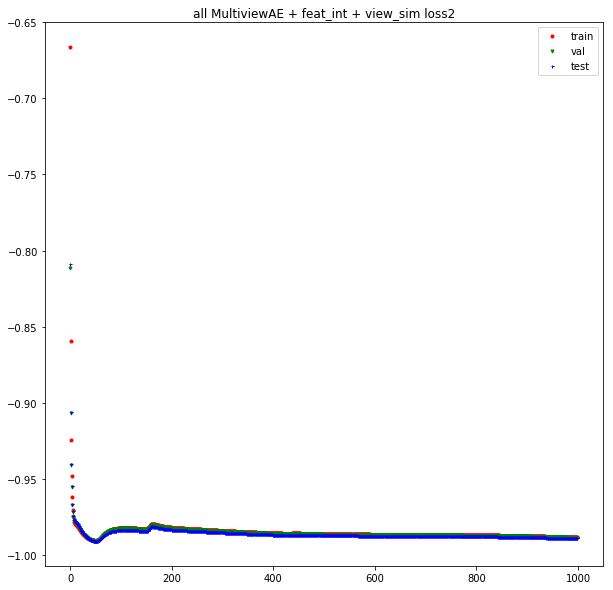

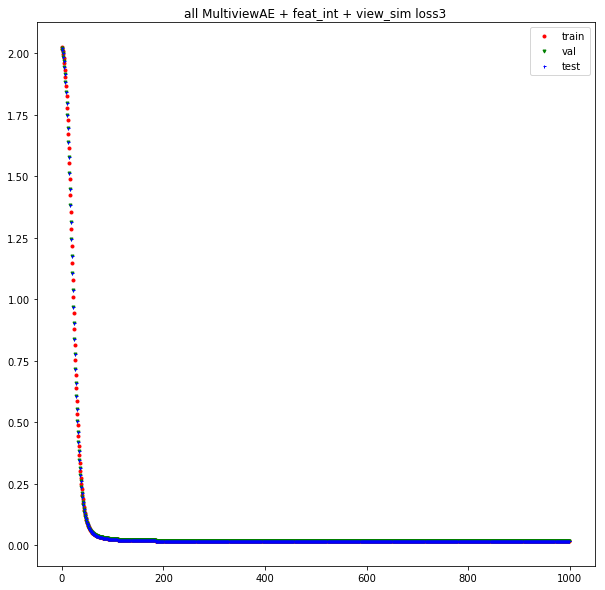

In [14]:
disease_type_str = 'all'#'0-1-6-8-10-11-16-17'
model_name = 'resnet'
sel_set_idx = 1
data_type_str = 'gene-mirna-rppa-methy'
data_split_str = '70-10-20'
hidden_dim_str = '100-100'
filefolder = 'results'
target_variable = 'pfi'
plot_acc = True
plot_loss = True
filename = (f'{filefolder}/{disease_type_str}_{data_type_str}_set{sel_set_idx}' 
            f'_{data_split_str}_{target_variable}_{hidden_dim_str}_{model_name}.pkl')
  

with open(filename, 'rb') as f:
  data = pickle.load(f)

metric = np.array(data['metric_all'])
confusion_mat = np.array(data['confusion_mat_all'])
model_names, split_names, metric_names = (data['model_names'], data['split_names'], 
                                          data['metric_names'])
assert metric.shape == (len(model_names), len(split_names), len(metric_names))
assert confusion_mat.shape[:2] == (len(model_names), len(split_names))
loss_his = data['loss_his_all']
acc_his = np.array(data['acc_his_all'])
title =  disease_type_str if len(disease_type_str)>2 else disease_stats[int(disease_type_str)]
if len(acc_his)>0 and plot_acc:
  for i, n in enumerate(split_names):
    plot_history(acc_his[:, i].T, title=f'{title} {n} acc', 
                 indices=None, colors='rgbkmc', markers='ov+*,<',
                     labels=model_names, linestyles=['']*6, markersize=3)
  for i, n in enumerate(model_names):
    plot_history(acc_his[i].T, title=f'{title} {n} acc', 
                 indices=None, colors='rgbkmc', markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
if len(loss_his)>0 and plot_loss:
  for i, n in enumerate(model_names):
    history = np.array(loss_his[i])
    if history.ndim == 2:
      plot_history(history.T, title=f'{title} {n} loss', indices=None, colors='rgbkmc', 
                   markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
    elif history.ndim == 3:
      for j in range(history.shape[2]):
         plot_history(history[:,:,j].T, title=f'{title} {n} loss{j}', indices=None, 
                      colors='rgbkmc', markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
    else:
      raise ValueError(f'{filename} {n} loss has unexpected shape')

['MultiviewAE + view_sim', 'MultiviewAE + feat_int + view_sim', 'MultiviewAE + view_sim', 'MultiviewAE + feat_int + view_sim', 'MultiviewAE + feat_int + view_sim', 'NN', 'NN']


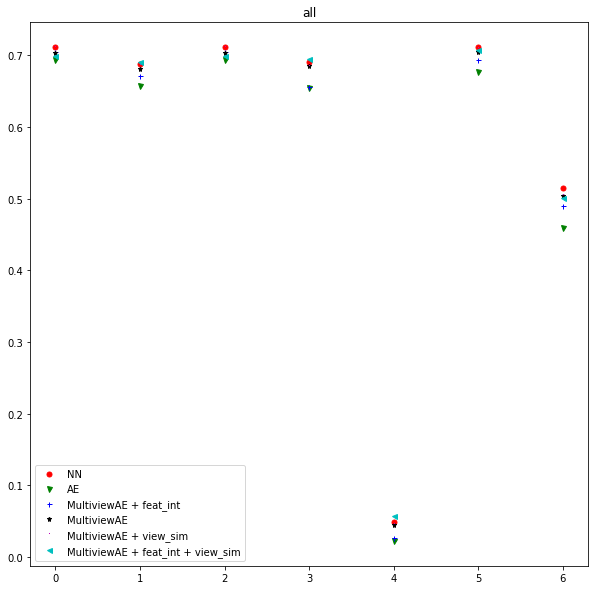

In [15]:
print([model_names[i] for i in metric[:, 2,:].argmax(axis=0)])
plot_history(metric[:, 2, :].T, title=title, 
               indices=None, colors='rgbkmc', markers='ov+*,<',
                   labels=model_names, linestyles=['']*6, markersize=5)

# I updated my code and run all the experiments again but only for 100 iterations


In [16]:
load_results(return_variable='metric_names', 
  filename=(f'results/PFI_instance-shuffle_gene-methy-mirna-rppa_all'
            f'_100-0_0.7-0.1-0.2_10sets_0_100-100_nn.pkl'))

array(['acc', 'precision', 'recall', 'f1_score', 'adjusted_mutual_info',
       'auc', 'average_precision'], dtype='<U20')

In [78]:
# study if model architectures (number of layers and hidden units) affect performances
target_variable = 'PFI' # 'DFI'
res_all = np.stack([np.concatenate([load_results(return_variable='metric_all', 
             filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
               f'_100-0_0.7-0.1-0.2_10sets_{seed}_{hidden_dim_str}_nn.pkl')) 
 for hidden_dim_str in hidden_dim_strs], axis=0) 
           for seed in range(10)], axis=0)

model_names_all = np.concatenate([[f'{n}_{hidden_dim_str}' 
                                   for n in load_results(return_variable='model_names', 
  filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
            f'_100-0_0.7-0.1-0.2_10sets_0_{hidden_dim_str}_nn.pkl'))] 
  for hidden_dim_str in hidden_dim_strs], axis=0)
model_names_all = np.array([s.replace(' ', '') for s in model_names_all])
model_names_all = np.array([s.replace('MultiviewAE', 'MAE') for s in model_names_all])

metric_idx = 3
split_idx = 2
# i = 5
# subset = range(6*i, 6*i+6)
# subset = range(i, len(model_names_all), 6)
subset = range(len(model_names_all))
if res_all.ndim==4:
  mean = res_all.mean(axis=0)[subset]
  std = res_all.std(axis=0)[subset]
else:
  mean = res_all[subset]
  std = np.zeros_like(mean)
model_names = model_names_all[subset]
sorted_idx = np.argsort(-mean, axis=0)
mean = mean[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
std = std[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
names = model_names[sorted_idx[:, split_idx, metric_idx]]
res = [(i+1, n, m, sd) for i, (n, m, sd) in enumerate(zip(names, mean, std))]
print('{:^4} {:^50} {:^5} \t {:^5}'.format('Rank', 'Name', 'Mean', 'Std'))
for s in res:
  print(f'{s[0]:^4} {s[1]:^50} {s[2]:^.3f} \t {s[3]:^.3f}')

Rank                        Name                        Mean  	  Std 
 1                MAE+feat_int_200-100-50               0.704 	 0.016
 2                       NN_200-100                     0.698 	 0.020
 3                     MAE_200-100-50                   0.698 	 0.016
 4             MAE+feat_int+view_sim_200-100            0.697 	 0.021
 5                     AE_50-100-200                    0.697 	 0.017
 6                  MAE+feat_int_100-100                0.697 	 0.022
 7                    MAE+feat_int_200                  0.697 	 0.022
 8                     AE_100-50-200                    0.697 	 0.020
 9                       AE_200-100                     0.696 	 0.029
 10                       MAE_200                       0.696 	 0.021
 11                    NN_200-100-50                    0.696 	 0.019
 12                      NN_100-100                     0.695 	 0.021
 13                    NN_100-50-200                    0.695 	 0.022
 14               MA

In [15]:
# study if densenet and resnet are better than mlp
target_variable = 'DFI'
model_types = ['ml', 'nn', 'densenet', 'resnet']
hidden_dim_str = '100-100'
# # Another set of of experiments
# model_types = ['nn', 'densenet', 'resnet']
# hidden_dim_str = '100-100-100'
res_all = np.stack([np.concatenate([load_results(return_variable='metric_all', 
             filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
               f'_100-0_0.7-0.1-0.2_10sets_{seed}_{hidden_dim_str}_{model_name}.pkl')) 
 for model_name in model_types], axis=0) 
           for seed in range(10)], axis=0)

model_names_all = np.concatenate([[f'{n}_{model_name}' 
                                   for n in load_results(return_variable='model_names', 
  filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
            f'_100-0_0.7-0.1-0.2_10sets_0_100-100_{model_name}.pkl'))] 
  for model_name in model_types], axis=0)
model_names_all = np.array([s.replace(' ', '') for s in model_names_all])
model_names_all = np.array([s.replace('MultiviewAE', 'MAE') for s in model_names_all])

idx = 5
# i = 0
# subset = range(6*i, 6*i+6)
# subset = range(i, len(model_names_all), 6)
subset = range(len(model_names_all))
names = model_names_all[subset][res_all.mean(axis=0)[subset].argsort(axis=0)[:,2,idx]]
values = np.sort(res_all.mean(axis=0)[subset], axis=0)[:,2,idx]
[(i, n, v) for i, (n, v) in enumerate(zip(names, values))]

[(0, 'DecisionTree_ml', 0.615138713340662),
 (1, 'AdaBoost_ml', 0.6536686605499994),
 (2, 'NaiveBayes_ml', 0.6621494633652854),
 (3, 'SVM_ml', 0.666422231657248),
 (4, 'kNN_ml', 0.6761643386473469),
 (5, 'RandomForest_ml', 0.7095824166248332),
 (6, 'NN_nn', 0.7285493247847519),
 (7, 'AE_resnet', 0.7294813714736484),
 (8, 'AE_nn', 0.7320083985321523),
 (9, 'NN_resnet', 0.7334649738738823),
 (10, 'MAE+view_sim_nn', 0.7356455582785124),
 (11, 'MAE+feat_int+view_sim_nn', 0.7356623946033019),
 (12, 'MAE_nn', 0.736574777802274),
 (13, 'MAE+feat_int+view_sim_resnet', 0.7369381198253732),
 (14, 'NN_densenet', 0.7376390649598321),
 (15, 'MAE+feat_int+view_sim_densenet', 0.7381172816760693),
 (16, 'MAE+view_sim_resnet', 0.7385015683316253),
 (17, 'AE_densenet', 0.7389606957635992),
 (18, 'MAE+view_sim_densenet', 0.7398047232901519),
 (19, 'MAE+feat_int_resnet', 0.7399788677773388),
 (20, 'MAE+feat_int_densenet', 0.74165869352945),
 (21, 'MAE+feat_int_nn', 0.7421439752021826),
 (22, 'MAE_resnet',

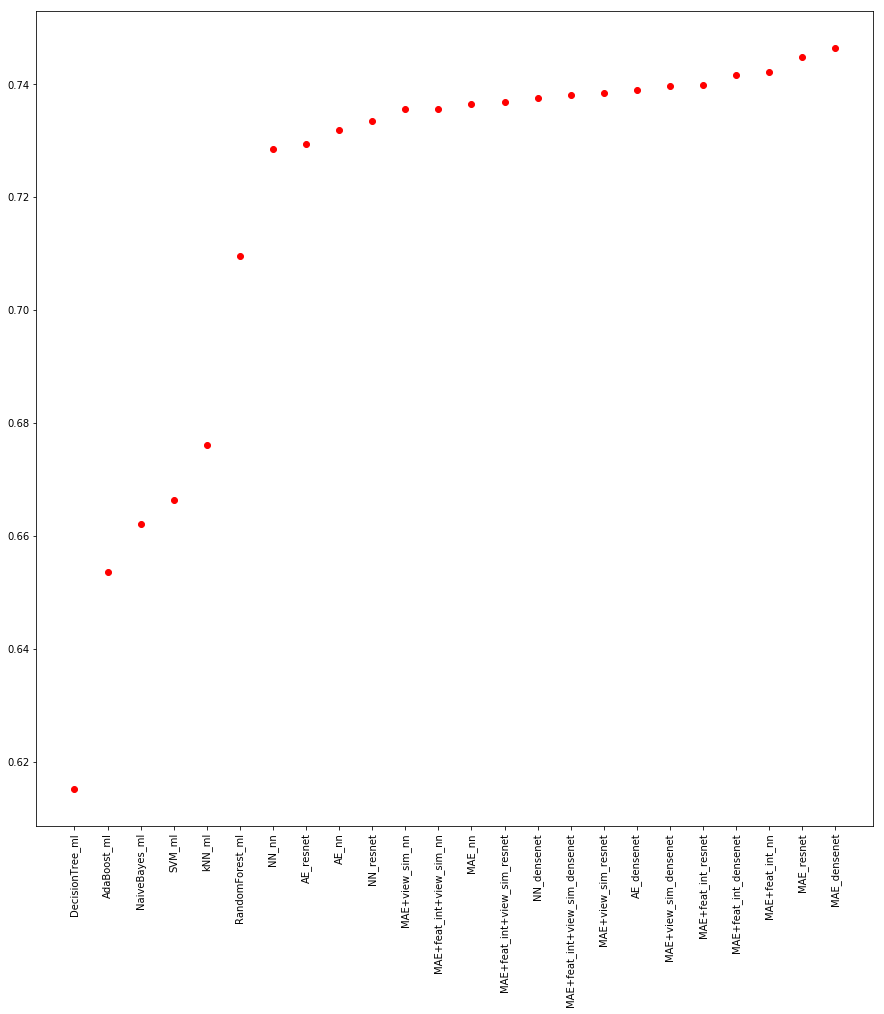

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(np.sort(res_all.mean(axis=0), axis=0)[:,2,idx], 'ro')
ax.set_xticks(np.arange(len(model_names_all)))
ax.set_xticklabels(model_names_all[res_all.mean(axis=0).argsort(axis=0)[:,2,idx]], rotation=90)
plt.show()

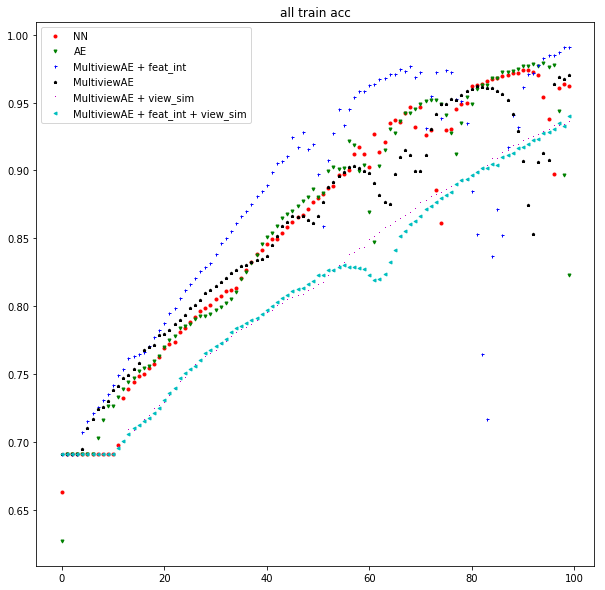

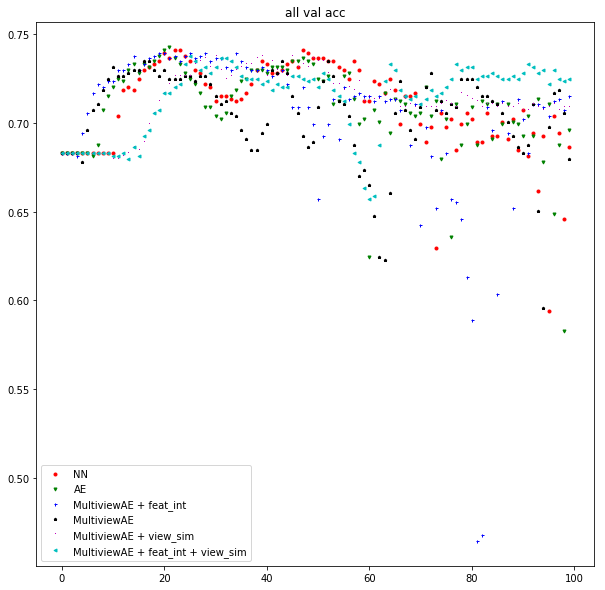

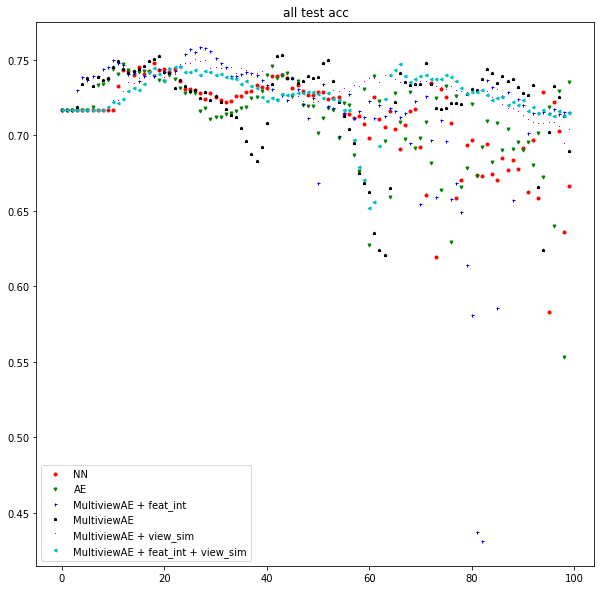

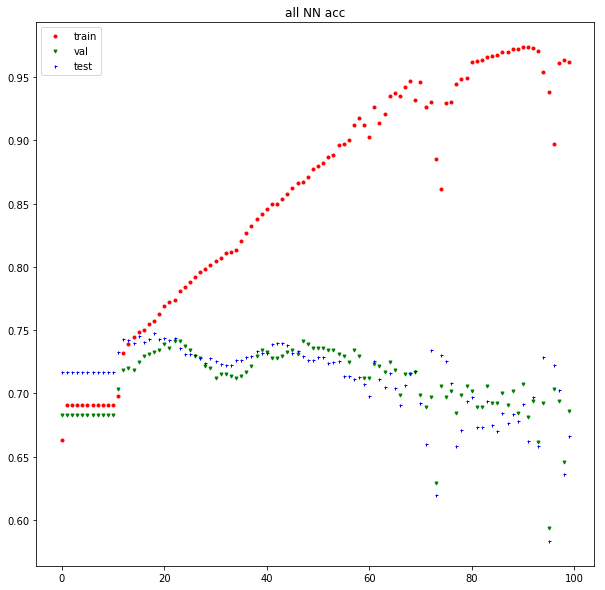

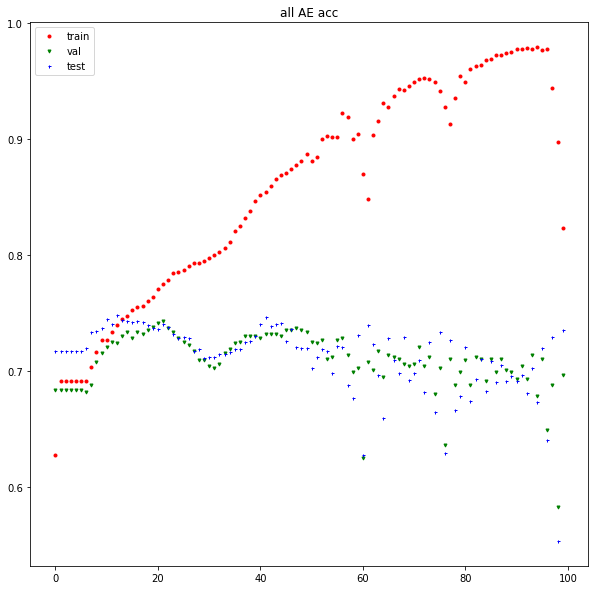

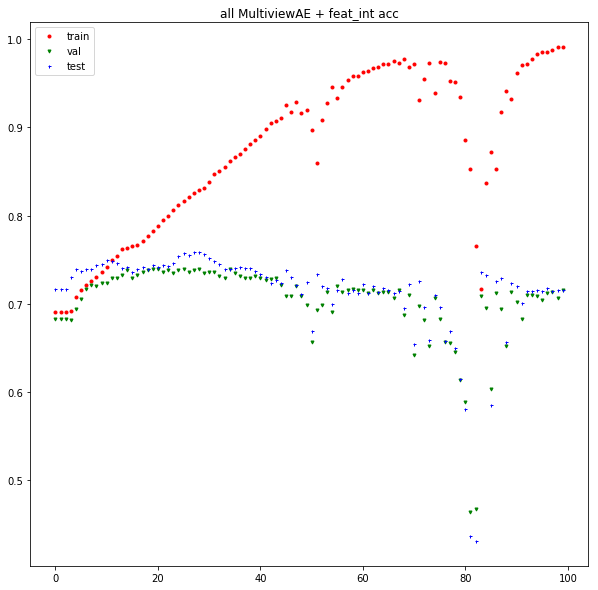

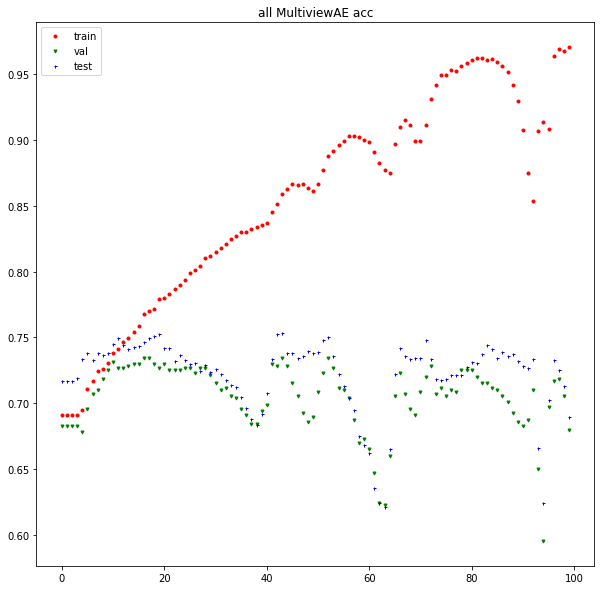

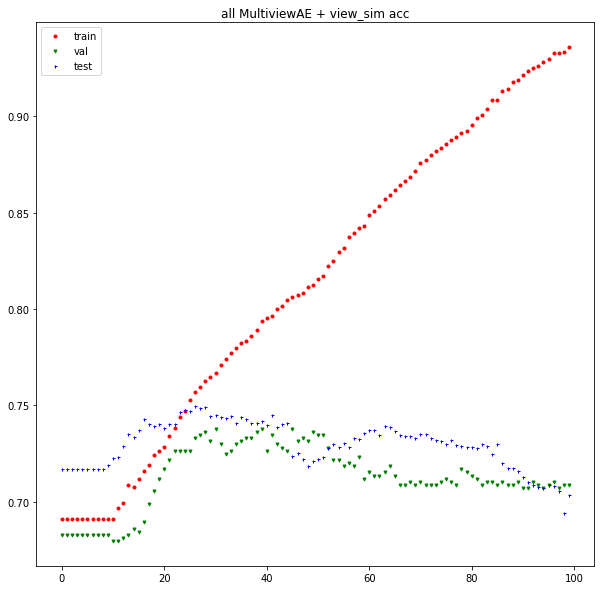

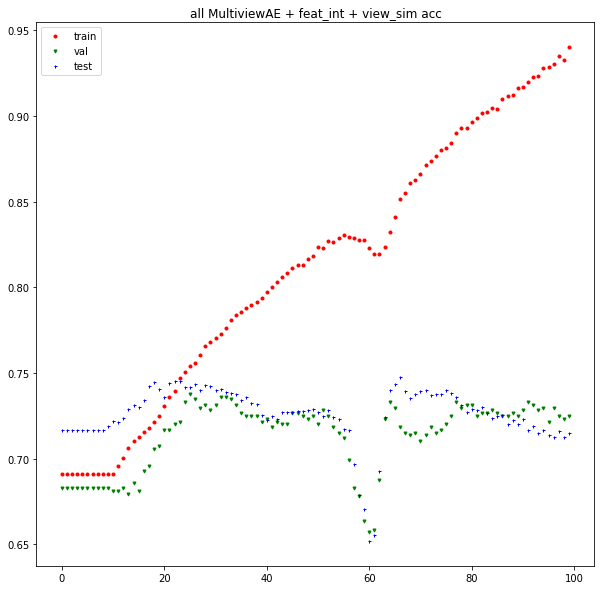

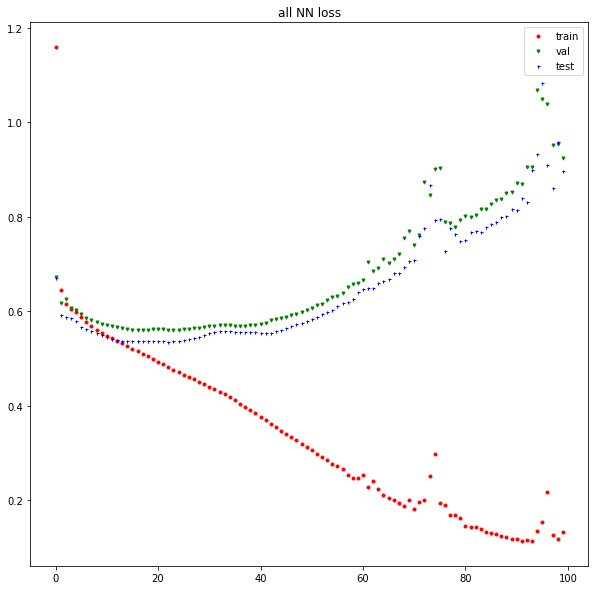

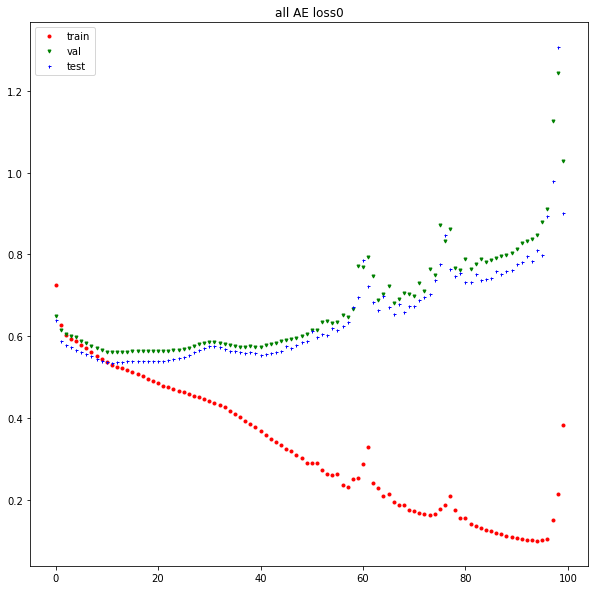

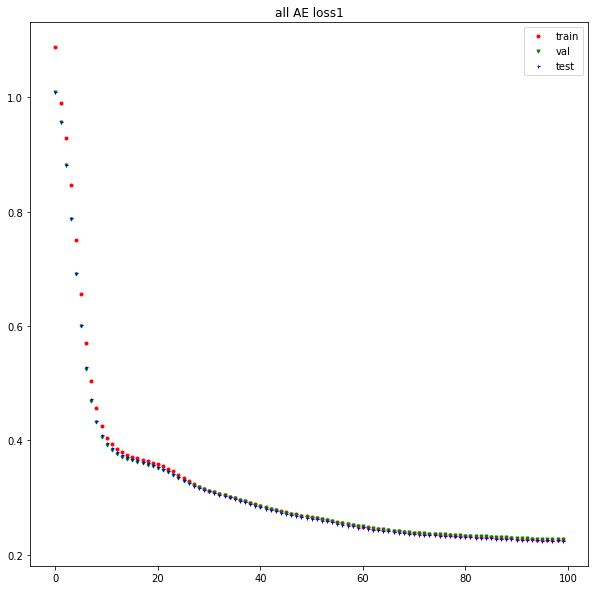

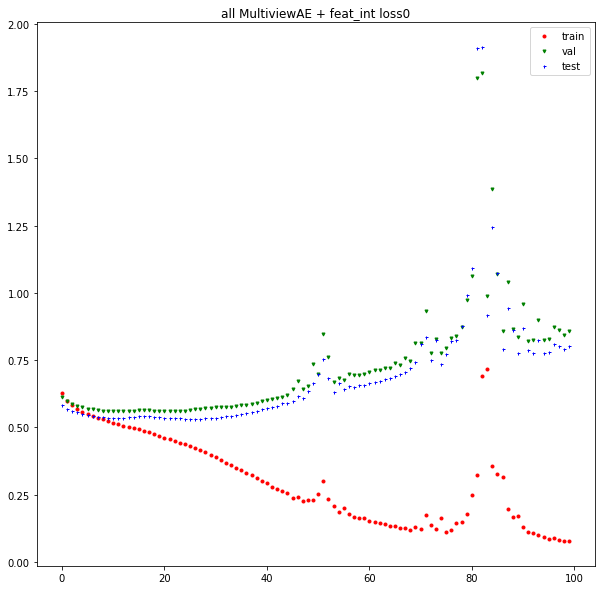

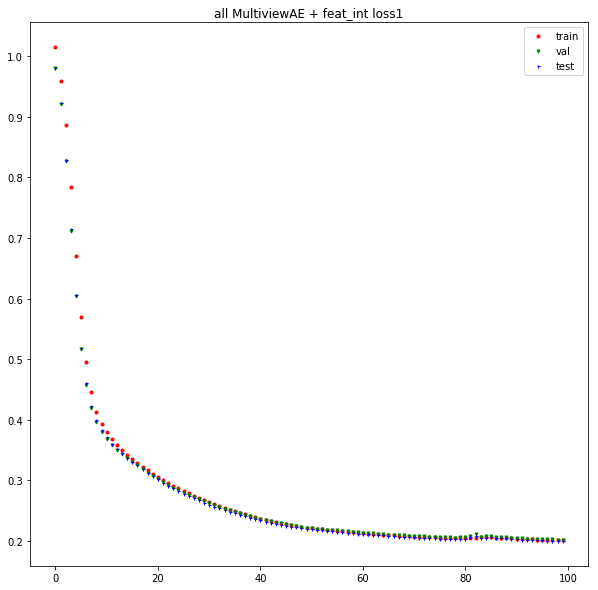

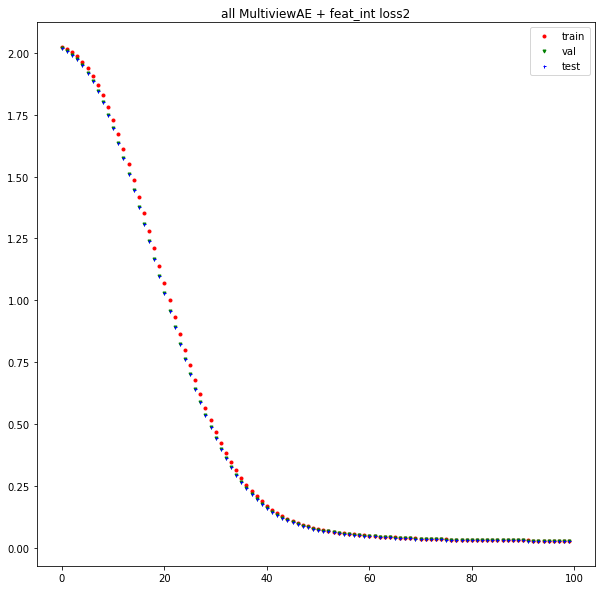

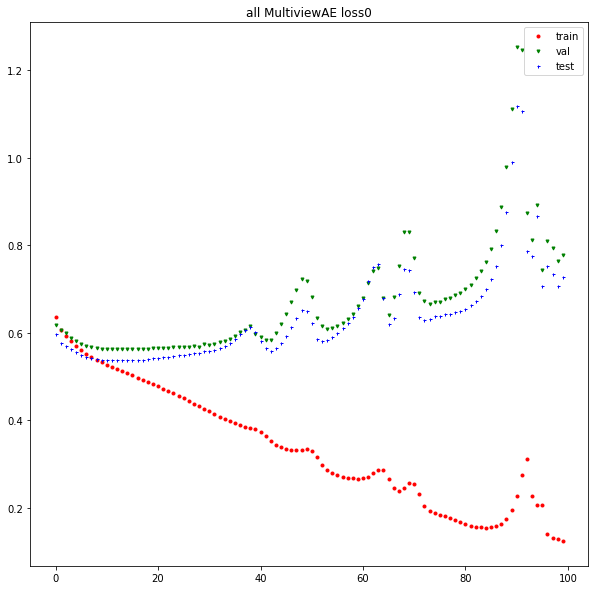

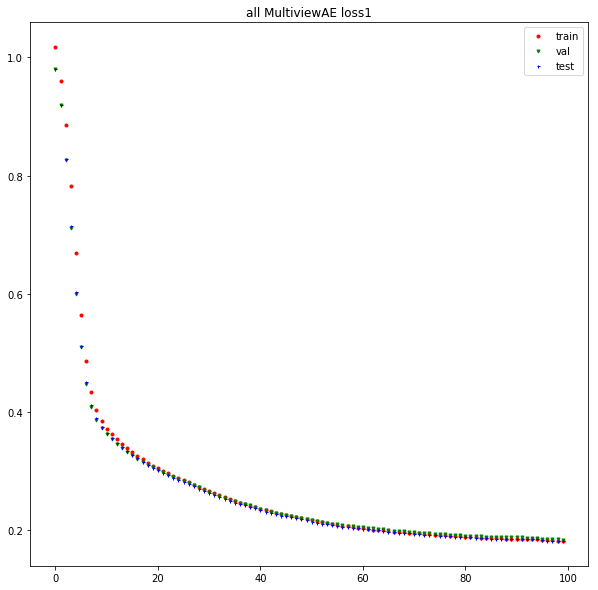

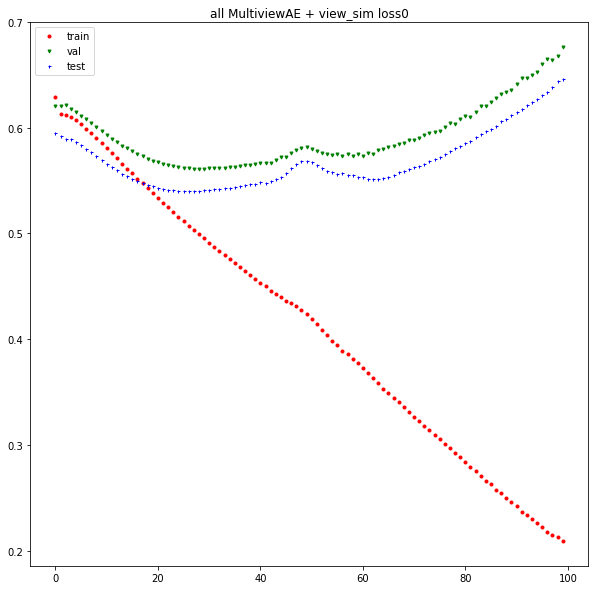

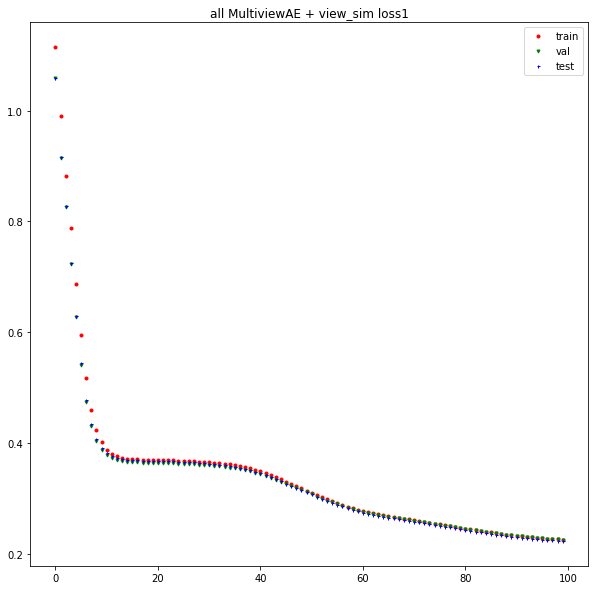

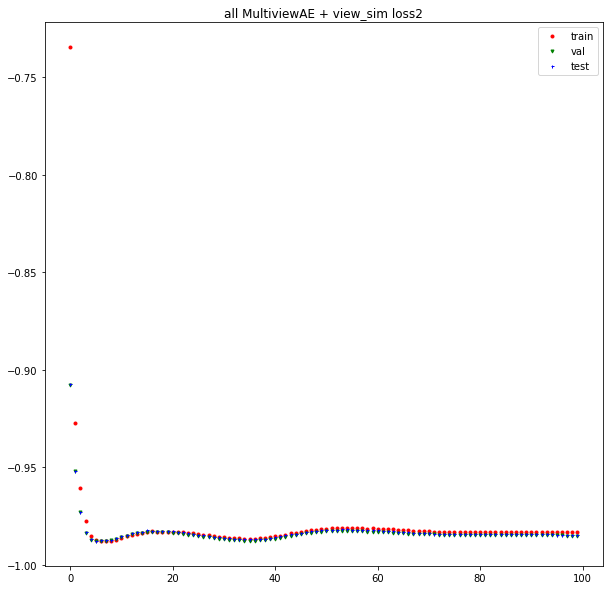

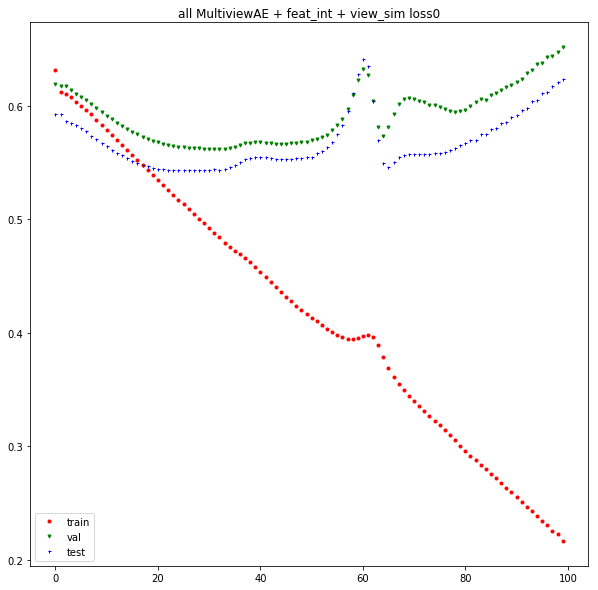

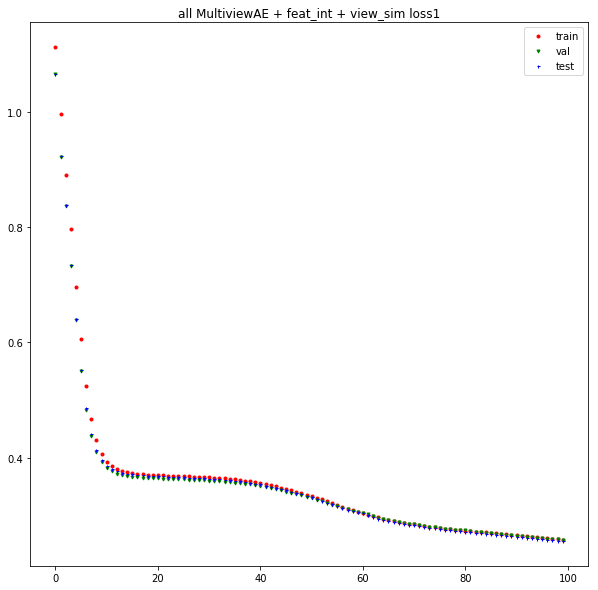

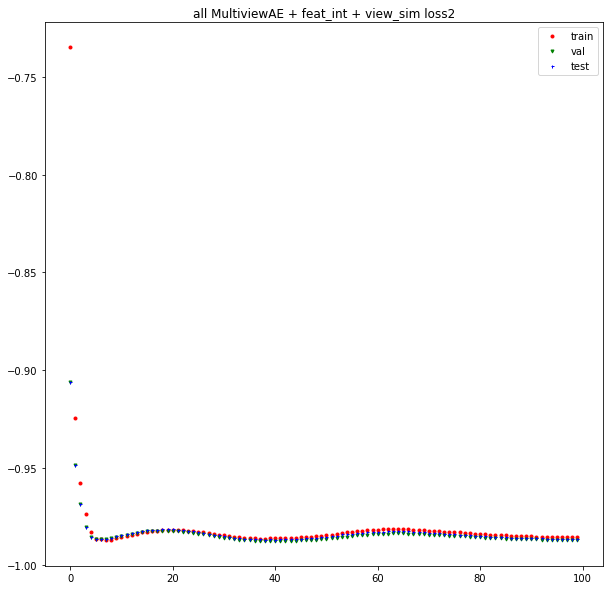

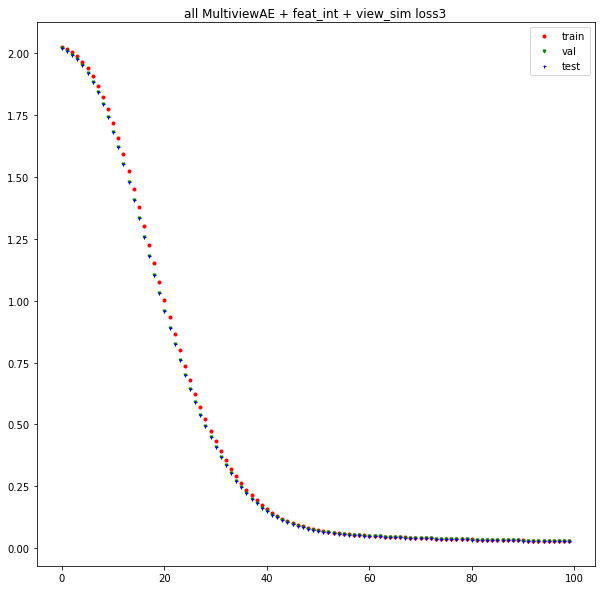

In [17]:
target_variable = 'PFI' # 'DFI'
model_name = 'densenet'
sel_set_idx = 1
hidden_dim_str = '100-100'
filefolder = 'results'
plot_acc = True
plot_loss = True
filename = (f'{filefolder}/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
            f'_100-0_0.7-0.1-0.2_10sets_{sel_set_idx}_{hidden_dim_str}_{model_name}.pkl')
  

with open(filename, 'rb') as f:
  data = pickle.load(f)

metric = np.array(data['metric_all'])
confusion_mat = np.array(data['confusion_mat_all'])
model_names, split_names, metric_names = (data['model_names'], data['split_names'], 
                                          data['metric_names'])
assert metric.shape == (len(model_names), len(split_names), len(metric_names))
assert confusion_mat.shape[:2] == (len(model_names), len(split_names))
loss_his = data['loss_his_all']
acc_his = np.array(data['acc_his_all'])
title =  disease_type_str if len(disease_type_str)>2 else disease_stats[int(disease_type_str)]
if len(acc_his)>0 and plot_acc:
  for i, n in enumerate(split_names):
    plot_history(acc_his[:, i].T, title=f'{title} {n} acc', 
                 indices=None, colors='rgbkmc', markers='ov+*,<',
                     labels=model_names, linestyles=['']*6, markersize=3)
  for i, n in enumerate(model_names):
    plot_history(acc_his[i].T, title=f'{title} {n} acc', 
                 indices=None, colors='rgbkmc', markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
if len(loss_his)>0 and plot_loss:
  for i, n in enumerate(model_names):
    history = np.array(loss_his[i])
    if history.ndim == 2:
      plot_history(history.T, title=f'{title} {n} loss', indices=None, colors='rgbkmc', 
                   markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
    elif history.ndim == 3:
      for j in range(history.shape[2]):
         plot_history(history[:,:,j].T, title=f'{title} {n} loss{j}', indices=None, 
                      colors='rgbkmc', markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
    else:
      raise ValueError(f'{filename} {n} loss has unexpected shape')

['MultiviewAE', 'MultiviewAE', 'MultiviewAE', 'MultiviewAE + feat_int', 'MultiviewAE + feat_int', 'MultiviewAE + feat_int + view_sim', 'AE']


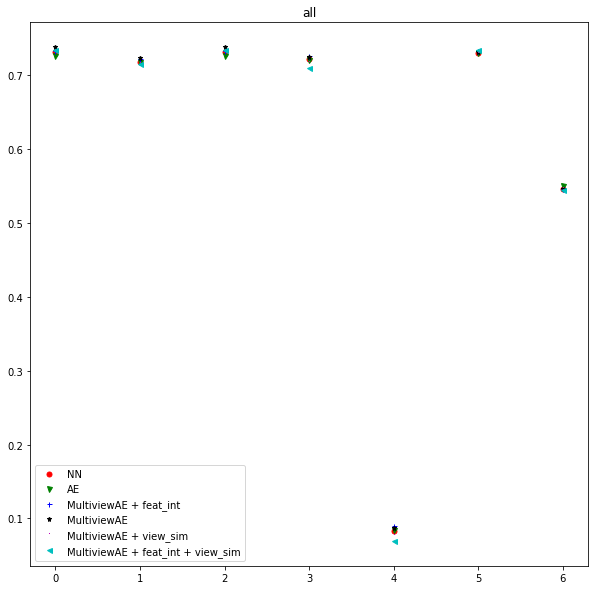

In [18]:
print([model_names[i] for i in metric[:, 2,:].argmax(axis=0)])
plot_history(metric[:, 2, :].T, title=title, 
               indices=None, colors='rgbkmc', markers='ov+*,<',
                   labels=model_names, linestyles=['']*6, markersize=5)

In [19]:
# experiment with 50-20-30 data split
# group shuffle seems not work well
target_variable = 'DFI' # 'PFI'
shuffle_type = 'instance-shuffle' # 'group-shuffle'
res_all = load_results(return_variable='metric_all', 
             filename=(f'results/{target_variable}_{shuffle_type}_gene-methy-mirna-rppa_all'
               f'_100-0_0.5-0.2-0.3_10sets_0_100-100_nn.pkl'))

model_names_all = load_results(return_variable='model_names', 
  filename=(f'results/{target_variable}_{shuffle_type}_gene-methy-mirna-rppa_all'
            f'_100-0_0.5-0.2-0.3_10sets_0_100-100_nn.pkl'))
model_names_all = np.array([s.replace(' ', '') for s in model_names_all])
model_names_all = np.array([s.replace('MultiviewAE', 'MAE') for s in model_names_all])

idx = 5
split_idx = 2
# i = 3
# subset = range(6*i, 6*i+6)
# subset = range(i, len(model_names_all), 6)
subset = range(len(model_names_all))
names = model_names_all[subset][res_all[subset].argsort(axis=0)[:,split_idx,idx]]
values = np.sort(res_all[subset], axis=0)[:,split_idx,idx]
[(i, n, v) for i, (n, v) in enumerate(zip(names, values))]

[(0, 'MAE+feat_int+view_sim', 0.7246425833220583),
 (1, 'MAE+view_sim', 0.7254243148574091),
 (2, 'MAE', 0.7305206031359461),
 (3, 'MAE+feat_int', 0.731911183270945),
 (4, 'NN', 0.7328357311444851),
 (5, 'AE', 0.7350230761135916)]